# **Train Model With Data Augmentation**<br/>
**Master's Degree in Data Science (A.Y. 2023/2024)**<br/>
**University of Milano - Bicocca**<br/>

Vittorio Haardt, Luca Porcelli

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Data Extraction Train

In [ ]:
!unzip "/content/gdrive/MyDrive/VIPM/Dataset/train_filtered_nest.zip" -d train

# Installing packages and loading libraries

In [ ]:
pip install imagecorruptions

In [ ]:
pip install efficientnet

In [ ]:
pip install keras_core

In [ ]:
pip install keras_cv

In [ ]:
from collections import defaultdict
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import os
import keras_core
from keras.models import load_model
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from keras.metrics import TopKCategoricalAccuracy
from keras.layers import GlobalAveragePooling2D
import keras_cv
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
import imgaug.augmenters as iaa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from efficientnet.keras import EfficientNetB0
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import random

Using TensorFlow backend


# Weight setting

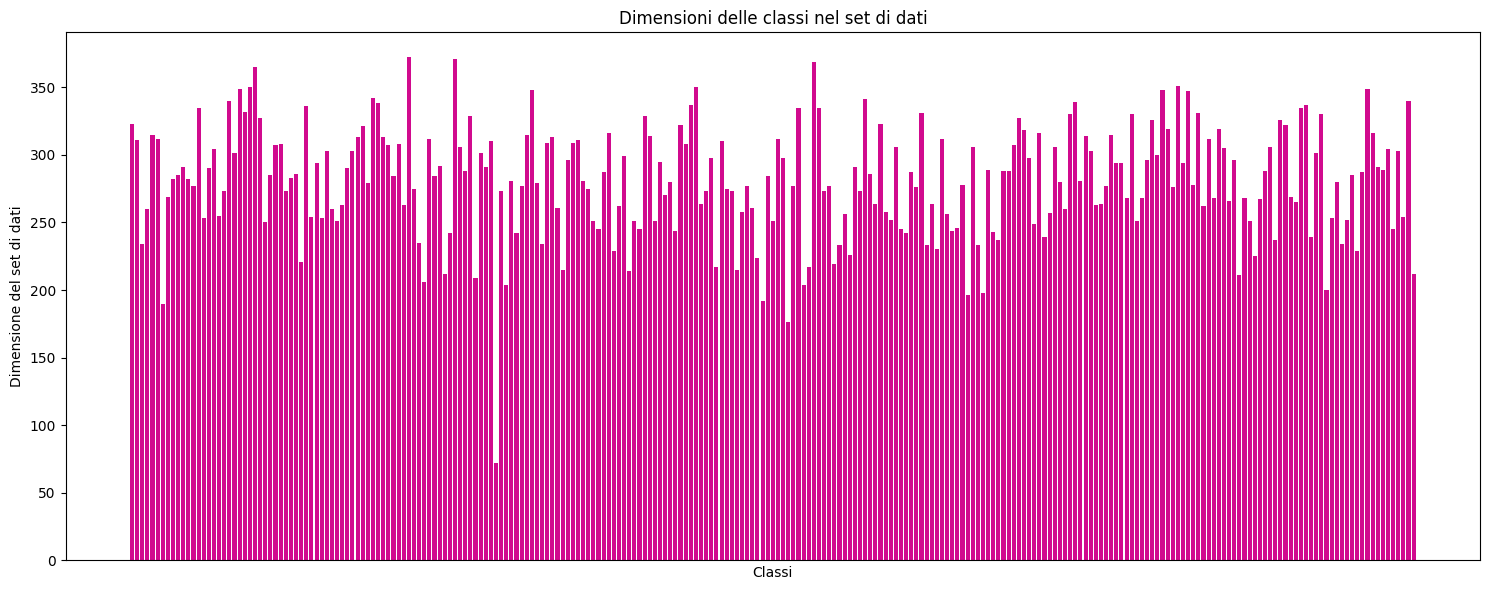

In [ ]:
# Define the path of the original folder
original_data_dir = '/content/train/train_filtered_prova'

# Get the list of all classes in your dataset
all_classes = sorted(os.listdir(original_data_dir))

# Calculate the original sizes of the classes
original_sizes = [len(os.listdir(os.path.join(original_data_dir, class_label))) for class_label in all_classes]

# Choose a random pastel color
pastel_color = "#{:06x}".format(random.randint(0, 0xFFFFFF))

# Create the bar chart without values above the bars
plt.figure(figsize=(15, 6))
bars = plt.bar(all_classes, original_sizes, color=pastel_color)  # Random pastel color

plt.xlabel('Classes')
plt.ylabel('Dataset Size')
plt.title('Class Sizes in the Dataset')

# Hide labels on the x-axis
plt.xticks([])

plt.tight_layout()
plt.show()

In [ ]:
def calculate_class_weights(data_dir):
    class_weights = {}
    label_indices = {}
    index = 0

    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            num_images = len(os.listdir(label_dir))  # Count the number of images in the folder
            class_weights[index] = num_images  # Calculate class weight as the inverse of the number of images
            label_indices[label] = index  # Store the current index associated with the label in the map
            index += 1  # Increment the current index.

    # Calculate normalized weights (total sum = 1) by dividing each class weight by the sum of all weights and multiplying by the total number of classes.
    total_sum = sum(class_weights.values())
    class_weights_normalized = {label: total_sum / (weight * len(class_weights)) for label, weight in class_weights.items()}

    return class_weights_normalized

train_class_weights = calculate_class_weights('/content/train/train_filtered_prova')

# Data augmentation demonstration

The `apply_random_noise` function adds random noise to the input image, `apply_gaussian_blur` applies Gaussian blur, and `apply_jpeg_compression` simulates JPEG compression with a specified quality level. These functions can be used for data augmentation.

In [ ]:
# Custom preprocessing functions
def apply_random_noise(image):
    #Applies random noise to the input image
    noise = np.random.randint(-100, 100+1, image.shape)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image.astype(np.uint8)

def apply_gaussian_blur(image):
    #Applies Gaussian blur to the input image
    return cv2.GaussianBlur(image, (15, 15), 0)

def apply_jpeg_compression(image, quality=1):
    #Applies JPEG compression to the input image
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, encoded_image = cv2.imencode('.jpg', image, encode_param)
    return cv2.imdecode(encoded_image, 1)


Text(0.5, 1.0, 'jpeg Compression')

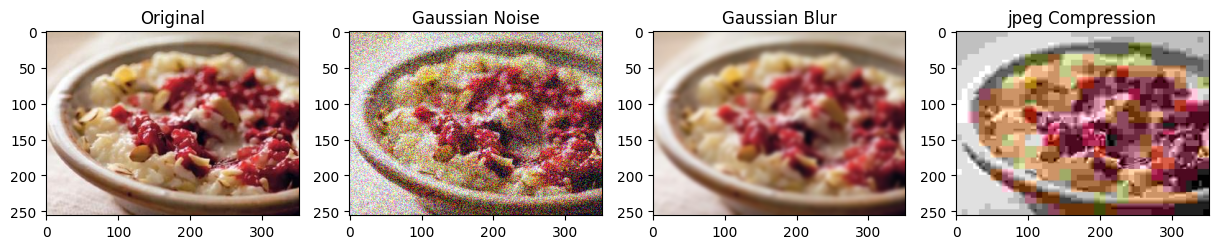

In [ ]:
# Load an image
image_path = '/content/train/train_filtered_prova/0/train_000711.jpg'
original_image = cv2.imread(image_path)

# Set the figure size
plt.figure(figsize=(15, 5))

# Display the original image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original')

# Apply transformations
augmented_image1 = apply_random_noise(original_image)
augmented_image2 = apply_gaussian_blur(original_image)
augmented_image3 = apply_jpeg_compression(original_image)

# Display transformed images
plt.subplot(1, 4, 2)
plt.imshow(cv2.cvtColor(augmented_image1, cv2.COLOR_BGR2RGB))
plt.title('Gaussian Noise')

plt.subplot(1, 4, 3)
plt.imshow(cv2.cvtColor(augmented_image2, cv2.COLOR_BGR2RGB))
plt.title('Gaussian Blur')

plt.subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(augmented_image3, cv2.COLOR_BGR2RGB))
plt.title('JPEG Compression')

# Train

This function `apply_augmentation` takes an input image and randomly applies one of four augmentations: Gaussian noise, Gaussian blur, no augmentation (original image), or JPEG compression. The choice is determined randomly using `random.randint(1, 4)`. The function then returns the augmented image.

In [ ]:
def apply_augmentation(image):
  i = random.randint(1, 4)
  if i==1:
    noise = np.random.randint(-100, 100+1, image.shape)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image.astype(np.uint8)
  elif i==2:
    return cv2.GaussianBlur(image, (15, 15), 0)
  elif i==3:
    return image
  else:
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 1]
    _, encoded_image = cv2.imencode('.jpg', image, encode_param)
    return cv2.imdecode(encoded_image, 1)

In [ ]:
datagen = ImageDataGenerator(
    validation_split=0.2,                     # Set the fraction of data to be used for validation
    preprocessing_function=apply_augmentation # Apply random noise/blur/JPEG compression
)

In [ ]:
# Create a dataset of images from the specified directory for training
train = datagen.flow_from_directory(
    "/content/train/train_filtered_prova",  # Path to the directory containing training images
    classes=None,                           # Use default class directories
    class_mode="categorical",               # Specify the encoding mode for labels
    color_mode="rgb",                       # RGB format for images
    batch_size=64,                          # Batch size
    target_size=(224, 224),                 # Set the dimensions of the images to 224x224 pixels
    shuffle=True,                           # Shuffle images within the dataset
    seed=777,                               # Seed for reproducibility
    subset="training"                       # Specify the training subset
)

Found 56547 images belonging to 251 classes.


In [ ]:
# Create a dataset of images from the specified directory for validation
val = datagen.flow_from_directory(
    "/content/train/train_filtered_prova",  # Path to the directory containing training images
    classes=None,                           # Use default class directories
    class_mode="categorical",               # Specify the encoding mode for labels
    color_mode="rgb",                       # RGB format for images
    batch_size=64,                          # Batch size
    target_size=(224, 224),                 # Set the dimensions of the images to 224x224 pixels
    shuffle=True,                           # Shuffle images within the dataset
    seed=777,                               # Seed for reproducibility
    subset="validation"                     # Specify the validation subset
)

Found 14012 images belonging to 251 classes.


# Models

## ResNet50

### Structure

In [ ]:
# Pretrained ResNet50 base model with ImageNet weights
base_net = keras.applications.ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
base_net.trainable = False  # Setting the layers of the base model as non-trainable

# Explicitly creating the input layer
inputs = keras.Input(shape=(224, 224, 3))
x = inputs
3
# Preprocessing the input using the ResNet50 preprocessing function
x = keras.applications.resnet50.preprocess_input(x)

# Passing the preprocessed input through the base model
x = base_net(x)

# GlobalAveragePooling2D to reduce spatial dimensions
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)  # Dropout for regularization

# Adding a dense layer for final classification with L2 regularization
outputs = keras.layers.Dense(251, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01))(x)

# Creating the specialized ResNet50 model
ResNet50_DA = keras.Model(inputs=inputs, outputs=outputs)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Definition of a function for learning rate scheduling
def decay_schedule(epoch, lr):
    # Check if the epoch is a multiple of 5 and if the epoch is not zero
    if (epoch % 5 == 0) and (epoch != 0):
        # Reduce the learning rate by 90%
        lr = lr * 0.1
    # Return the new learning rate value
    return lr

# Creating a LearningRateScheduler object using the learning rate schedule function
lr_scheduler = LearningRateScheduler(decay_schedule)

### Training

In [ ]:
# Compiling the model for training
ResNet50_DA.compile(
    loss='categorical_crossentropy',                                     # Categorical crossentropy loss for multi-class classification
    optimizer=Adam(0.0001),                                              # Adam optimizer with a learning rate of 0.0001
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]  # Metrics for evaluation during training
)

# Training the model
history = ResNet50_DA.fit(
    train,                             # Training data generator
    class_weight=train_class_weights,  # Class weights for handling class imbalance
    epochs=10,                         # Number of training epochs
    validation_data=val,               # Validation data generator
    callbacks=[lr_scheduler]           # Callback for learning rate scheduling
)


Epoch 1/10
884/884 [==============================] - 335s 361ms/step - loss: 9.0173 - accuracy: 0.0216 - top_k_categorical_accuracy: 0.0745 - val_loss: 7.6242 - val_accuracy: 0.0447 - val_top_k_categorical_accuracy: 0.1340 - lr: 1.0000e-04
Epoch 2/10
884/884 [==============================] - 299s 339ms/step - loss: 6.9490 - accuracy: 0.0686 - top_k_categorical_accuracy: 0.1913 - val_loss: 6.5657 - val_accuracy: 0.0798 - val_top_k_categorical_accuracy: 0.2035 - lr: 1.0000e-04
Epoch 3/10
884/884 [==============================] - 297s 336ms/step - loss: 5.9918 - accuracy: 0.1073 - top_k_categorical_accuracy: 0.2644 - val_loss: 6.0247 - val_accuracy: 0.0994 - val_top_k_categorical_accuracy: 0.2348 - lr: 1.0000e-04
Epoch 4/10
884/884 [==============================] - 298s 337ms/step - loss: 5.4619 - accuracy: 0.1356 - top_k_categorical_accuracy: 0.3137 - val_loss: 5.7278 - val_accuracy: 0.1046 - val_top_k_categorical_accuracy: 0.2486 - lr: 1.0000e-04
Epoch 5/10
884/884 [================

### Saving model

In [ ]:
ResNet50_DA.save('/content/gdrive/MyDrive/VIPM/Models/ResNet50_DA.h5')
ResNet50_DA.save('/content/gdrive/MyDrive/VIPM/Models/ResNet50_DA.Keras')

### Model performance graphs

In [ ]:
import plotly.graph_objects as go

# Loss
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['loss']) + 1)),
    y=history.history['loss'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['val_loss']) + 1)),
    y=history.history['val_loss'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

# Accuracy
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['accuracy']) + 1)),
    y=history.history['accuracy'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['val_accuracy']) + 1)),
    y=history.history['val_accuracy'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Accuracy'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()


## ResNet101

### Structure

In [ ]:
# Pretrained ResNet101 base model with ImageNet weights
base_resnet_model = ResNet101(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
trainable_layer = False  # Setting the layers of the base model as non-trainable

# Explicitly creating the input layer
inputs = keras.Input(shape=(224, 224, 3))
x = inputs

# Preprocessing the input using the ResNet101 preprocessing function
x = keras.applications.resnet.preprocess_input(x)

# Passing the preprocessed input through the base model
x = base_resnet_model(x)

# GlobalAveragePooling2D to reduce spatial dimensions
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)  # Dropout for regularization

# Adding a dense layer for final classification with L2 regularization
outputs = keras.layers.Dense(251, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01))(x)

# Creating the specialized ResNet101 model
ResNet101_DA = keras.Model(inputs=inputs, outputs=outputs)

171446536/171446536 [==============================] - 1s 0us/step


In [ ]:
# Definition of a function for learning rate scheduling
def decay_schedule(epoch, lr):
    # Check if the epoch is a multiple of 5 and if the epoch is not zero
    if (epoch % 5 == 0) and (epoch != 0):
        # Reduce the learning rate by 90%
        lr = lr * 0.1
    # Return the new learning rate value
    return lr

# Creating a LearningRateScheduler object using the learning rate schedule function
lr_scheduler = LearningRateScheduler(decay_schedule)

### Training

In [ ]:
# Compiling the model for training
ResNet101_DA.compile(
    loss='categorical_crossentropy',                                     # Categorical crossentropy loss for multi-class classification
    optimizer=Adam(0.0001),                                              # Adam optimizer with a learning rate of 0.0001
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]  # Metrics for evaluation during training
)

# Training the model
history = ResNet101_DA.fit(
    train,                             # Training data generator
    class_weight=train_class_weights,  # Class weights for handling class imbalance
    epochs=10,                         # Number of training epochs
    validation_data=val,               # Validation data generator
    callbacks=[lr_scheduler]           # Callback for learning rate scheduling
)

Epoch 1/10
884/884 [==============================] - 1225s 1s/step - loss: 7.4220 - accuracy: 0.1234 - top_k_categorical_accuracy: 0.2827 - val_loss: 6.5881 - val_accuracy: 0.1465 - val_top_k_categorical_accuracy: 0.3137 - lr: 1.0000e-04
Epoch 2/10
884/884 [==============================] - 1138s 1s/step - loss: 4.8840 - accuracy: 0.2888 - top_k_categorical_accuracy: 0.5360 - val_loss: 5.6983 - val_accuracy: 0.2023 - val_top_k_categorical_accuracy: 0.3790 - lr: 1.0000e-04
Epoch 3/10
884/884 [==============================] - 1138s 1s/step - loss: 3.9136 - accuracy: 0.3713 - top_k_categorical_accuracy: 0.6222 - val_loss: 5.3158 - val_accuracy: 0.2231 - val_top_k_categorical_accuracy: 0.3986 - lr: 1.0000e-04
Epoch 4/10
884/884 [==============================] - 1142s 1s/step - loss: 3.3304 - accuracy: 0.4326 - top_k_categorical_accuracy: 0.6758 - val_loss: 5.3134 - val_accuracy: 0.2166 - val_top_k_categorical_accuracy: 0.3877 - lr: 1.0000e-04
Epoch 5/10
884/884 [========================

### Saving model

In [ ]:
ResNet101_DA.save('/content/gdrive/MyDrive/VIPM/Models/ResNet101_DA.h5')
ResNet101_DA.save('/content/gdrive/MyDrive/VIPM/Models/ResNet101_DA.Keras')

### Model performance graphs

In [ ]:
import plotly.graph_objects as go

# Loss
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['loss']) + 1)),
    y=history.history['loss'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['val_loss']) + 1)),
    y=history.history['val_loss'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

# Accuracy
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['accuracy']) + 1)),
    y=history.history['accuracy'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['val_accuracy']) + 1)),
    y=history.history['val_accuracy'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Accuracy'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()


## EfficientNetB0

### Structure

In [ ]:
# Pretrained EfficientNetB0 base model with ImageNet weights
base_eff_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3))
trainable_layer = False  # Setting the layers of the base model as non-trainable

# Explicitly creating the input layer
inputs = keras.Input(shape=(224, 224, 3))
x = inputs

# Preprocessing the input using the EfficientNetB0 preprocessing function
x = keras.applications.efficientnet.preprocess_input(x)

# Passing the preprocessed input through the base model
x = base_eff_model(x)

# GlobalAveragePooling2D to reduce spatial dimensions
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.3)(x)  # Dropout for regularization

# Adding a dense layer for final classification with L2 regularization
outputs = keras.layers.Dense(251, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01))(x)

# Creating the specialized EfficientNet_DA model
EfficientNet_DA = keras.Model(inputs=inputs, outputs=outputs)

16804768/16804768 [==============================] - 0s 0us/step


In [ ]:
# Definition of a function for learning rate scheduling
def decay_schedule(epoch, lr):
    # Check if the epoch is a multiple of 5 and if the epoch is not zero
    if (epoch % 5 == 0) and (epoch != 0):
        # Reduce the learning rate by 90%
        lr = lr * 0.1
    # Return the new learning rate value
    return lr

# Creating a LearningRateScheduler object using the learning rate schedule function
lr_scheduler = LearningRateScheduler(decay_schedule)

### Training

In [ ]:
# Compiling the model for training
EfficientNet_DA.compile(
    loss='categorical_crossentropy',                                     # Categorical crossentropy loss for multi-class classification
    optimizer=Adam(0.0001),                                              # Adam optimizer with a learning rate of 0.0001
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]  # Metrics for evaluation during training
)

# Training the model
history = EfficientNet_DA.fit(
    train,                           # Training data generator
    epochs=10,                       # Number of training epochs
    validation_data=val,             # Validation data generator
    callbacks=[lr_scheduler]         # Callback for learning rate scheduling
)

Epoch 1/10
884/884 [==============================] - 562s 587ms/step - loss: 7.3866 - accuracy: 0.0548 - top_k_categorical_accuracy: 0.1505 - val_loss: 6.0844 - val_accuracy: 0.1047 - val_top_k_categorical_accuracy: 0.2545 - lr: 1.0000e-04
Epoch 2/10
884/884 [==============================] - 488s 552ms/step - loss: 4.9287 - accuracy: 0.1942 - top_k_categorical_accuracy: 0.4220 - val_loss: 5.2649 - val_accuracy: 0.1677 - val_top_k_categorical_accuracy: 0.3468 - lr: 1.0000e-04
Epoch 3/10
884/884 [==============================] - 488s 551ms/step - loss: 4.1742 - accuracy: 0.2646 - top_k_categorical_accuracy: 0.5116 - val_loss: 4.9987 - val_accuracy: 0.1940 - val_top_k_categorical_accuracy: 0.3770 - lr: 1.0000e-04
Epoch 4/10
884/884 [==============================] - 488s 552ms/step - loss: 3.8210 - accuracy: 0.3046 - top_k_categorical_accuracy: 0.5572 - val_loss: 4.8719 - val_accuracy: 0.2138 - val_top_k_categorical_accuracy: 0.3942 - lr: 1.0000e-04
Epoch 5/10
884/884 [================

### Saving model

In [ ]:
EfficientNet_DA.save('/content/gdrive/MyDrive/VIPM/Models/EfficientNet_DA.h5')
EfficientNet_DA.save('/content/gdrive/MyDrive/VIPM/Models/EfficientNet_DA.Keras')

### Model performance graphs

In [ ]:
import plotly.graph_objects as go

# Loss
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['loss']) + 1)),
    y=history.history['loss'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['val_loss']) + 1)),
    y=history.history['val_loss'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Loss',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()

# Accuracy
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['accuracy']) + 1)),
    y=history.history['accuracy'],
    mode='lines',
    name='Train',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['val_accuracy']) + 1)),
    y=history.history['val_accuracy'],
    mode='lines',
    name='Validation',
    line=dict(color='orange')
))

fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Accuracy'),
    legend=dict(font=dict(size=12)),
    height=500,
    width=600
)

fig.show()